# Model Tuning
Tristan Miller

Although I've settled on the XGB model, I think it can be improved further by including features from previous timeblocks (as a sort of poor man's LSTM).  So now I need to optimize the model again.  The four knobs I want to tune are:
1. Number of previous timeblocks to include.
1. Maximum Depth
1. Number estimators
1. Learning rate

I also have two constraints:
1. Time.  Performing a full grid search takes a prohibitive amount of it.  And if I use trees with larger maximum depth, there will need to be fewer number of estimators.
1. Disk space.  I'd like to avoid paying for another AWS machine, so the data must be 5 GB at most.  That means that if I include features from previous timeblocks, I also need to select only a subset of what is currently used.

As far as disk space goes, I have a solution.  Previously, I multiplied the training set size by including transposed copies of it.  I think I can preserve the diversity of the set by randomly transposing each timeblock rather than including transposed copies of each timeblock.  This will reduce the disk space usage by a factor of 12.

Max depth and learning rate are hard to optimize, because in principle they should depend on how large the training set is, so using a fraction of the training set isn't really a valid method of tuning.  Increased max depth, increased number of estimators, and increased learning rate (I think) all result in a lower-bias model, which is better for a larger training set.

So here's my roadmap to tuning the model:
1. Create a data set that includes the previous 7 timeblocks, and train a relatively fast-to-train XGB model.  Look at feature importance and see if there's a time when it drops off.
2. Estimate training time for different values of max_depth, and for each value of max_depth, set num_estimators so the training time is a constant (say 1 or 2 hours).
3. Using a single value of learning_rate, scan max_depth.
4. Using the best value of max_depth, scan learning_rate.

## Setup

In [135]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys, os
from sklearn.model_selection import train_test_split
import sklearn
import re
import pickle
import xgboost as xgb
import sklearn
from xgboost import plot_importance

if 'chord_loader' in sys.modules:
    del sys.modules['chord_loader']
sys.path.append('.')
import chord_loader

## Feature engineering

In [107]:
def multi_feature_reduce(features, n_multi):
    '''Eliminates additional transposed copies of training set, 
    and generates multiple copies of features from previous timeblocks'''
    og_size = int(features.shape[0]/12)
    n_features = features.shape[1]-1
    np.random.seed(35402374)
    randomizer = np.random.randint(12,size=og_size)*og_size+range(og_size)
    
    output = np.ndarray((og_size,n_features*n_multi+1))
    output[:,:(n_features+1)] = features[:og_size,:]
    within_song = (1 - features[1:og_size,0]).reshape(og_size-1,1)
    for i in range(1,n_multi):
        output[i:,(n_features*i+1):(n_features*(i+1)+1)] = features[randomizer[i:]-i,1:] * within_song
        within_song = np.logical_and(within_song[1:],within_song[:-1]).reshape(og_size-i-1,1)
    return output

def multi_feature(features, n_multi):
    '''Generates multiple copies of features from previous timeblocks'''
    n_samples = features.shape[0]
    n_features = features.shape[1]-1
    
    output = np.ndarray((n_samples,n_features*n_multi+1))
    output[:,:(n_features+1)] = features[:,:]
    within_song = (1 - features[1:,0]).reshape(n_samples-1,1)
    for i in range(1,n_multi):
        output[i:,(n_features*i+1):(n_features*(i+1)+1)] = features[:(-i),1:] * within_song
        within_song = np.logical_and(within_song[1:],within_song[:-1]).reshape(n_samples-i-1,1)
    return output

In [109]:
n_multi = 8

In [121]:
og_features_train = np.load(f'Data/processed/full_ftrain.npy')
mixed_features_train = multi_feature_reduce(og_features_train,n_multi)
og_size = int(og_features_train.shape[0]/12)
features_train = multi_feature(og_features_train[:og_size,:],n_multi)
og_labels_train = np.load(f'Data/processed/full_ltrain.npy')
labels_train = labels_train[:og_size,:]
np.random.seed(35402374)
randomizer = np.random.randint(12,size=og_size)*og_size+range(og_size)
mixed_labels_train = og_labels_train[randomizer,:]
np.save(f'Data/processed/multi_ftrain.npy',mixed_features_train)
np.save(f'Data/processed/multi_ltrain.npy',mixed_labels_train)
standard_features_train, standard_labels_train = chord_loader.standardize_root(features_train,labels_train,1,transposed=False)
np.save(f'Data/processed/multi_fstrain.npy',standard_features_train)
np.save(f'Data/processed/multi_lstrain.npy',standard_labels_train)

features_valid = multi_feature(np.load(f'Data/processed/full_fvalid.npy'),n_multi)
labels_valid = np.load(f'Data/processed/full_lvalid.npy')
np.save(f'Data/processed/multi_fvalid.npy',features_valid)
np.save(f'Data/processed/multi_lvalid.npy',labels_valid)
standard_features_valid, standard_labels_valid = chord_loader.standardize_root(features_valid,labels_valid,1,transposed=False)
np.save(f'Data/processed/multi_fsvalid.npy',standard_features_valid)
np.save(f'Data/processed/multi_lsvalid.npy',standard_labels_valid)

features_test = multi_feature(np.load(f'Data/processed/full_ftest.npy'),n_multi)
labels_test = np.load(f'Data/processed/full_ltest.npy')
np.save(f'Data/processed/multi_ftest.npy',features_test)
np.save(f'Data/processed/multi_ltest.npy',labels_test)
standard_features_test, standard_labels_test = chord_loader.standardize_root(features_test,labels_test,1,transposed=False)
np.save(f'Data/processed/multi_fstest.npy',standard_features_test)
np.save(f'Data/processed/multi_lstest.npy',standard_labels_test)

## Testing feature importance

Just train a small forest for now.  Note that the metric calculation step doesn't work, but I'll fix that later.

```python chord_train.py multi xgb_multitest xgb --params T 10 5 0.1```

In [136]:
with open(f"Models/xgb_multitest.pkl", 'rb') as f:
    root_model = pickle.load(f)
    quality_model = pickle.load(f)
    add_model = pickle.load(f)
    inv_model = pickle.load(f)

/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [161]:
root_feature_importance = np.mean(root_model.feature_importances_[1:].reshape(95,8),axis=0)
quality_feature_importance = np.mean(quality_model.feature_importances_[1:].reshape(95,8),axis=0)
add_feature_importance = np.mean(add_model.feature_importances_[1:].reshape(95,8),axis=0)
inv_feature_importance = np.mean(inv_model.feature_importances_[1:].reshape(95,8),axis=0)

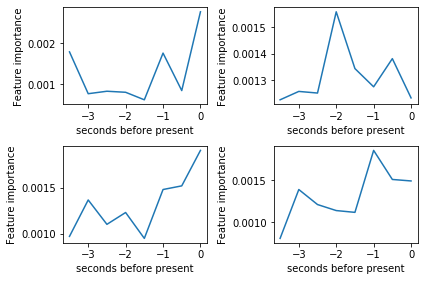

In [172]:
plt.rc('font', size=10)
plt.subplot(2,2,1)
plt.plot(np.arange(0,-4,-0.5),root_feature_importance)
plt.xlabel('seconds before present')
plt.ylabel('Feature importance')
plt.subplot(2,2,2)
plt.plot(np.arange(0,-4,-0.5),quality_feature_importance)
plt.xlabel('seconds before present')
plt.ylabel('Feature importance')
plt.subplot(2,2,3)
plt.plot(np.arange(0,-4,-0.5),add_feature_importance)
plt.xlabel('seconds before present')
plt.ylabel('Feature importance')
plt.subplot(2,2,4)
plt.plot(np.arange(0,-4,-0.5),inv_feature_importance)
plt.xlabel('seconds before present')
plt.ylabel('Feature importance')
plt.tight_layout()

These results are pretty noisy, but the majority of results suggest I get the most benefit by going back just 1 s in time.

In [173]:
n_multi = 3

In [174]:
og_features_train = np.load(f'Data/processed/full_ftrain.npy')
mixed_features_train = multi_feature_reduce(og_features_train,n_multi)
og_size = int(og_features_train.shape[0]/12)
features_train = multi_feature(og_features_train[:og_size,:],n_multi)
og_labels_train = np.load(f'Data/processed/full_ltrain.npy')
labels_train = labels_train[:og_size,:]
np.random.seed(35402374)
randomizer = np.random.randint(12,size=og_size)*og_size+range(og_size)
mixed_labels_train = og_labels_train[randomizer,:]
np.save(f'Data/processed/multi_ftrain.npy',mixed_features_train)
np.save(f'Data/processed/multi_ltrain.npy',mixed_labels_train)
standard_features_train, standard_labels_train = chord_loader.standardize_root(features_train,labels_train,1,transposed=False)
np.save(f'Data/processed/multi_fstrain.npy',standard_features_train)
np.save(f'Data/processed/multi_lstrain.npy',standard_labels_train)

features_valid = multi_feature(np.load(f'Data/processed/full_fvalid.npy'),n_multi)
labels_valid = np.load(f'Data/processed/full_lvalid.npy')
np.save(f'Data/processed/multi_fvalid.npy',features_valid)
np.save(f'Data/processed/multi_lvalid.npy',labels_valid)
standard_features_valid, standard_labels_valid = chord_loader.standardize_root(features_valid,labels_valid,1,transposed=False)
np.save(f'Data/processed/multi_fsvalid.npy',standard_features_valid)
np.save(f'Data/processed/multi_lsvalid.npy',standard_labels_valid)

features_test = multi_feature(np.load(f'Data/processed/full_ftest.npy'),n_multi)
labels_test = np.load(f'Data/processed/full_ltest.npy')
np.save(f'Data/processed/multi_ftest.npy',features_test)
np.save(f'Data/processed/multi_ltest.npy',labels_test)
standard_features_test, standard_labels_test = chord_loader.standardize_root(features_test,labels_test,1,transposed=False)
np.save(f'Data/processed/multi_fstest.npy',standard_features_test)
np.save(f'Data/processed/multi_lstest.npy',standard_labels_test)

## Tuning max_depth

Test computation times:

```python chord_train.py multi xgb_d3 xgb --noT --params T 1 3 0.1;
python chord_train.py multi xgb_d5 xgb --noT --params T 1 5 0.1;
python chord_train.py multi xgb_d7 xgb --noT --params T 1 7 0.1;
python chord_train.py multi xgb_d9 xgb --noT --params T 1 9 0.1;
python chord_train.py multi xgb_d3 xgb --noT --params T 2 3 0.1;
python chord_train.py multi xgb_d5 xgb --noT --params T 2 5 0.1;
python chord_train.py multi xgb_d7 xgb --noT --params T 2 7 0.1;
python chord_train.py multi xgb_d9 xgb --noT --params T 2 9 0.1;```

Let's aim for one hour per model.  This can be calculated by taking the difference between one and two trees, and dividing 60 minutes.

Times:
- depth=3: 1.95 - 1.24 => 84 trees 
- depth=5: 2.96 - 1.74 => 49 trees 
- depth=7: 3.98 - 2.26 => 35 trees
- depth=9: 5.06 - 2.79 => 26 trees

```python chord_train.py multi xgb_d3 xgb --noT --params T 84 3 0.1;
python chord_train.py multi xgb_d5 xgb --noT --params T 49 5 0.1;
python chord_train.py multi xgb_d7 xgb --noT --params T 35 7 0.1;
python chord_train.py multi xgb_d9 xgb --noT --params T 26 9 0.1;```

In [188]:
metrics = [pickle.load(open("Models/xgb_d3_metrics.pkl", 'rb'))]
metrics.append(pickle.load(open("Models/xgb_d5_metrics.pkl", 'rb')))
metrics.append(pickle.load(open("Models/xgb_d7_metrics.pkl", 'rb')))
metrics.append(pickle.load(open("Models/xgb_d9_metrics.pkl", 'rb')))

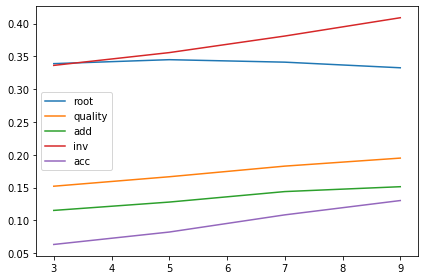

In [190]:
max_depth = [3,5,7,9]
plt.plot(max_depth, [m['root_macro_valid'] for m in metrics]);
plt.plot(max_depth, [m['quality_macro_valid'] for m in metrics]);
plt.plot(max_depth, [m['add_macro_valid'] for m in metrics]);
plt.plot(max_depth, [m['inv_macro_valid'] for m in metrics]);
plt.plot(max_depth, [m['total_acc_valid'] for m in metrics]);
#plt.xscale('log')
plt.legend(['root','quality','add','inv','acc'])
plt.tight_layout()

Okay, let's use depth 5 for root, and depth 9 for all the others.

## Tuning learning_rate

```python chord_train.py multi xgb_l002 xgb_supertuned --noT --params T 49 26 26 26 5 9 9 9 0.02 0.02 0.02 0.02;
python chord_train.py multi xgb_l005 xgb_supertuned --noT --params T 49 26 26 26 5 9 9 9 0.05 0.05 0.05 0.05;
python chord_train.py multi xgb_l01 xgb_supertuned --noT --params T 49 26 26 26 5 9 9 9 0.1 0.1 0.1 0.1;
python chord_train.py multi xgb_l02 xgb_supertuned --noT --params T 49 26 26 26 5 9 9 9 0.2 0.2 0.2 0.2;
python chord_train.py multi xgb_l04 xgb_supertuned --noT --params T 49 26 26 26 5 9 9 9 0.4 0.4 0.4 0.4;```

In [ ]:
metrics = [pickle.load(open("Models/xgb_l002_metrics.pkl", 'rb'))]
metrics.append(pickle.load(open("Models/xgb_l005_metrics.pkl", 'rb')))
metrics.append(pickle.load(open("Models/xgb_l01_metrics.pkl", 'rb')))
metrics.append(pickle.load(open("Models/xgb_l02_metrics.pkl", 'rb')))
metrics.append(pickle.load(open("Models/xgb_l04_metrics.pkl", 'rb')))

In [ ]:
learning_rate = [0.02,0.05,0.1,0.2,0.4]
plt.figure(figsize=(6,4))
plt.plot(learning_rate, [m['root_macro_valid'] for m in metrics],'-o');
plt.plot(learning_rate, [m['quality_macro_valid'] for m in metrics],'-o');
plt.plot(learning_rate, [m['add_macro_valid'] for m in metrics],'-o');
plt.plot(learning_rate, [m['inv_macro_valid'] for m in metrics],'-o');
plt.plot(learning_rate, [m['total_acc_valid'] for m in metrics],'-o');
plt.xlabel('Learning rate')
plt.ylabel('Performance (preliminary)')
plt.xscale('log')
plt.legend(['F1 Root','F1 Quality','F1 Add','F1 Inversion','Total accuracy'],bbox_to_anchor=(1.3, .5),loc='center')
plt.tight_layout()
#plt.savefig('images/xgb_validation')